# Jędrzej Pawłowski nr. albumu: 13816 
## Projekt zaliczeniowy Metody Uczenia Maszynowego na podstawie dancyh z Instagram Usage Lifestyle
### !Ważne! ***Z Powodu dużego rozmiaru instagram_usage_lifestale.csv załączam w pliku rar (orginalnie ważył 410MB i nie mogłem przesłać na GitHub)**

## Importowanie

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize

np.random.seed(42)


### Wczytanie danych wejściowych


In [9]:
csv_path = "data/instagram_usage_lifestyle.csv"
df = pd.read_csv(csv_path)

print("Wymiary:", df.shape)
df.head()


Wymiary: (1547896, 58)


,user_id,app_name,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,...,last_login_date,average_session_length_minutes,content_type_preference,preferred_content_theme,privacy_setting_level,two_factor_auth_enabled,biometric_login_used,linked_accounts_count,subscription_status,user_engagement_score
0,1,Instagram,51,Female,India,Rural,High,Retired,Bachelor’s,Single,...,2025-11-02,5.0,Mixed,Tech,Private,Yes,No,0,Free,7.83
1,2,Instagram,64,Female,United Kingdom,Urban,Middle,Full-time employed,Other,Divorced,...,2025-03-22,14.8,Photos,Fashion,Public,No,No,3,Free,1.43
2,3,Instagram,41,Female,Canada,Urban,Middle,Student,Bachelor’s,In a relationship,...,2025-08-10,5.0,Mixed,Other,Public,Yes,Yes,1,Free,9.67
3,4,Instagram,27,Non-binary,South Korea,Urban,Middle,Unemployed,Master’s,In a relationship,...,2025-03-31,25.9,Stories,Tech,Private,No,No,1,Free,0.94
4,5,Instagram,55,Male,India,Urban,Upper-middle,Full-time employed,Bachelor’s,Single,...,2025-03-19,13.1,Videos,Food,Public,Yes,No,0,Free,1.03


## Opis zbioru danych

Do projektu wykorzystano zbiór danych **`instagram_usage_lifestyle.csv`**, który zawiera informacje o użytkownikach Instagrama oraz ich stylu życia i aktywności w aplikacji. Zbiur składa się z 1 547 896 obserwacji (wierszy) oraz 58 zmiennych (kolumn), czo czyni go dużym i przekrojowym zestawem danych nadającym się do analizy regresji.

Dane obejmują kilka głównych grup informacji:

### 1 Cechy demograficzne użytkownika
Zawierają podstawowe informacje opisujące użytkownika, np.:
- `age` (wiek),
- `gender` (płeć),
- `country` (kraj),
- `urban_rural` (miejsce zamieszkania: miasto/wieś),
- `education_level`, `employment_status`, `income_level` (wykształcenie, zatrudnienie, dochód),
- `relationship_status`, `has_children` (relacja, dzieci).

### 2 Styl życia i zdrowie
Dane opisujące codzienne nawyki i samopoczucie, np.:
- `sleep_hours_per_night` (sen),
- `exercise_hours_per_week` (aktywność fizyczna),
- `diet_quality` (jakość diety),
- `smoking`, `alcohol_frequency` (palenie, alkohol),
- `perceived_stress_score`, `self_reported_happiness` (stres, subiektywne szczęście),
- `daily_steps_count`, `weekly_work_hours` (kroki i czas pracy).

### 3 Sposób korzystania z Instagrama (zachowania w aplikacji)
Najważniejsza część zbioru, opisująca aktywność w aplikacji, m.in.:
- czas spędzony w aplikacji (`time_on_feed_per_day`, `time_on_reels_per_day`, `time_on_messages_per_day`),
- częstotliwość sesji (`sessions_per_day`, `average_session_length_minutes`),
- interakcje (`likes_given_per_day`, `comments_written_per_day`, `dms_sent_per_week`, `posts_created_per_week`),
- konsumowanie treści (`reels_watched_per_day`, `stories_viewed_per_day`),
- reklamy (`ads_viewed_per_day`, `ads_clicked_per_day`),
- parametry konta (`followers_count`, `following_count`, `account_creation_year`).

### 4 Zmienna objaśniana (cel regresji)
W projekcie przyjeto jako zmienną objaśnianą:
- **`user_engagement_score`** – wskaźnik poziomu zaangażowania użytkownika.

Celem projektu jest zbadanie, w jakim stopniu styl życia i sposób korzystania z aplikacji wpływa na poziom zaangażowania oraz przygotowanie modelu regresji przewidującego tę wartość.


### Szybki opis danych i przygotowanie celu


In [24]:
print(df.dtypes.head(20))
print("\nBraki danych (top 15 kolumn):")
display(df.isna().mean().sort_values(ascending=False).head(15))

# Target (cel regresji)
TARGET = "user_engagement_score"

# Kolumny, których nie chcemy jako cechy (ID/stałe)
drop_cols = ["user_id", "app_name"]

# Bezpieczeństwo: wyrzucamy wiersze bez targetu
df = df.dropna(subset=[TARGET]).copy()

# Daty: last_login_date -> cecha "days_since_last_login"
if "last_login_date" in df.columns:
    df["last_login_date"] = pd.to_datetime(df["last_login_date"], errors="coerce")
    max_date = df["last_login_date"].max()
    df["days_since_last_login"] = (max_date - df["last_login_date"]).dt.days
    # Możesz też wyrzucić oryginalną datę, bo model i tak jej nie zje bez kodowania
    df = df.drop(columns=["last_login_date"])

print("Po czyszczeniu:", df.shape)


user_id                      int64
app_name                    object
age                          int64
gender                      object
country                     object
urban_rural                 object
income_level                object
employment_status           object
education_level             object
relationship_status         object
has_children                object
exercise_hours_per_week    float64
sleep_hours_per_night      float64
diet_quality                object
smoking                     object
alcohol_frequency           object
perceived_stress_score       int64
self_reported_happiness      int64
body_mass_index            float64
blood_pressure_systolic      int64
dtype: object

Braki danych (top 15 kolumn):


user_id                     0.0
followers_count             0.0
reels_watched_per_day       0.0
stories_viewed_per_day      0.0
likes_given_per_day         0.0
comments_written_per_day    0.0
dms_sent_per_week           0.0
dms_received_per_week       0.0
ads_viewed_per_day          0.0
ads_clicked_per_day         0.0
time_on_feed_per_day        0.0
time_on_explore_per_day     0.0
time_on_messages_per_day    0.0
time_on_reels_per_day       0.0
following_count             0.0
dtype: float64

Po czyszczeniu: (1547896, 58)


## Czyszczenie danych – co usunięto i dlaczego?

Przed budową modeli konieczne było wykonanie podstawowego przygotowania danych, aby analiza była poprawna i możliwa do przeprowadzenia.

### 1 Usunięcie wierszy bez wartości zmiennej celu (`user_engagement_score`)
W analizie regresji nie można trenować modelu, jeśli brakuje wartości zmiennej objaśnianej.  
Dlatego usunięto rekordy, w których `user_engagement_score` było puste (`NaN`).

Usnięte ponieważ brak wartości celu uniemożliwia uczenie modelu i ocenę wynikuw.

### 2 Usunięcie identyfikatorów oraz pól technicznych nieprzydatnych w predykcji
Usunięto m.in.:
- `user_id` – unikalny identyfikator użytkownika,
- `app_name` – nazwa aplikacji (stała wartość dla całego zbioru).

 Usnięto poniewaz takie kolumny nie niosą informacji o zachowaniach użytkownika, a mogłyby wprowadzać szum lub sztucznie poprawiać dopasowanie (np. model „zapamiętałby” identyfikatory zamiast uczyć się zależności).


### Próbkowanie (żeby notebook działał szybko i “normalnie”)


In [25]:
N = 200_000
if len(df) > N:
    df_sample = df.sample(n=N, random_state=42)
else:
    df_sample = df

print("Próbka:", df_sample.shape)

X = df_sample.drop(columns=drop_cols + [TARGET], errors="ignore")
y = df_sample[TARGET].astype(float)

# Podział train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


Próbka: (200000, 58)


((160000, 55), (40000, 55))

### Regresja MNK (LinearRegression) + preprocessing (OneHot + skala)


In [26]:
# Rozdzielamy kolumny numeryczne i kategoryczne
numeric_features = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeryczne:", len(numeric_features))
print("Kategoryczne:", len(categorical_features))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

model_LR = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

model_LR


Numeryczne: 37
Kategoryczne: 18


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'exercise_hours_per_week',
                                                   'sleep_hours_per_night',
                                                   'perceived_stress_score',
                                                   'self_reported_happiness',
                                                   'body_mass_index',
                                                   'blood_pressure_systolic',
                                                   'blood_pressure_diastolic',
                                                   'daily_step...
                                                   'urban_rural',
                                                   'income_level',
                                                   'employment_status',
                                                   'education_level',
                                                   'relationship_status',
                                                   'has_children',
                                                   'diet_quality', 'smoking',
                                                   'alcohol_frequency',
                                                   'uses_premium_features',
                                                   'content_type_preference',
                                                   'preferred_content_theme',
                                                   'privacy_setting_level',
                                                   'two_factor_auth_enabled',
                                                   'biometric_login_used',
                                                   'subscription_status'])])),
                ('model', LinearRegression())])

In [27]:
model_LR.fit(X_train, y_train)

pred_train = model_LR.predict(X_train)
pred_test = model_LR.predict(X_test)

def regression_report(y_true, y_pred, label=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label} R^2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

regression_report(y_train, pred_train, "TRAIN")
regression_report(y_test, pred_test, "TEST")


TRAIN R^2: 0.5553 | MAE: 0.8269 | RMSE: 1.2066
TEST R^2: 0.5518 | MAE: 0.8268 | RMSE: 1.2054


C:\Users\jedre\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\jedre\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Interpretacja wyników Linear Regression (MNK)
- **R² = 0.5553 (train) / 0.5518 (test)**: Model wyjaśnia **~55% wariancji** zmiennej docelowej (engagement). Oznacza to, że połowa zmienności engagementu wynika z cech użytkownika, druga połowa to inne czynniki (treść, algorytm, nastrój użytkownika).
- **MAE = 0.8268**: Średni bląd bezwzględny ~0.83 punktu na skali engagementu
- **RMSE = 1.2054**: Pierwiastek błędu średniokwadratowego - większy wpływ mają duże błędy
- **Brak przeuczenia**: Wyniki train ≈ test, model dobrze uogólnia na nowe dane
- **Wniosek**: Model liniowy osiągaa umiarkowaną wydajność; relacje mogą mieć charakter nieliniowy


### “Ludzka” interpretacja: które cechy najbardziej wpływają na wynik (współczynniki)


In [28]:
# Wyciągamy nazwy cech po OneHot i skalowaniu
pre = model_LR.named_steps["preprocess"]
lr = model_LR.named_steps["model"]

feature_names_num = numeric_features

# OneHot nazwy
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
feature_names_cat = ohe.get_feature_names_out(categorical_features).tolist()

feature_names = feature_names_num + feature_names_cat

coefs = lr.coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs_coef"] = coef_df["coef"].abs()

# Top 20 “najmocniejszych” (po wartości bezwzględnej)
top = coef_df.sort_values("abs_coef", ascending=False).head(20)
top


,feature,coef,abs_coef
55,income_level_Low,2.068192e+12,2.068192e+12
56,income_level_Lower-middle,2.068192e+12,2.068192e+12
54,income_level_High,2.068192e+12,2.068192e+12
57,income_level_Middle,2.068192e+12,2.068192e+12
58,income_level_Upper-middle,2.068192e+12,2.068192e+12
89,alcohol_frequency_Several times a week,1.927811e+12,1.927811e+12
90,alcohol_frequency_Weekly,1.927811e+12,1.927811e+12
88,alcohol_frequency_Rarely,1.927811e+12,1.927811e+12
87,alcohol_frequency_Never,1.927811e+12,1.927811e+12
86,alcohol_frequency_Daily,1.927811e+12,1.927811e+12


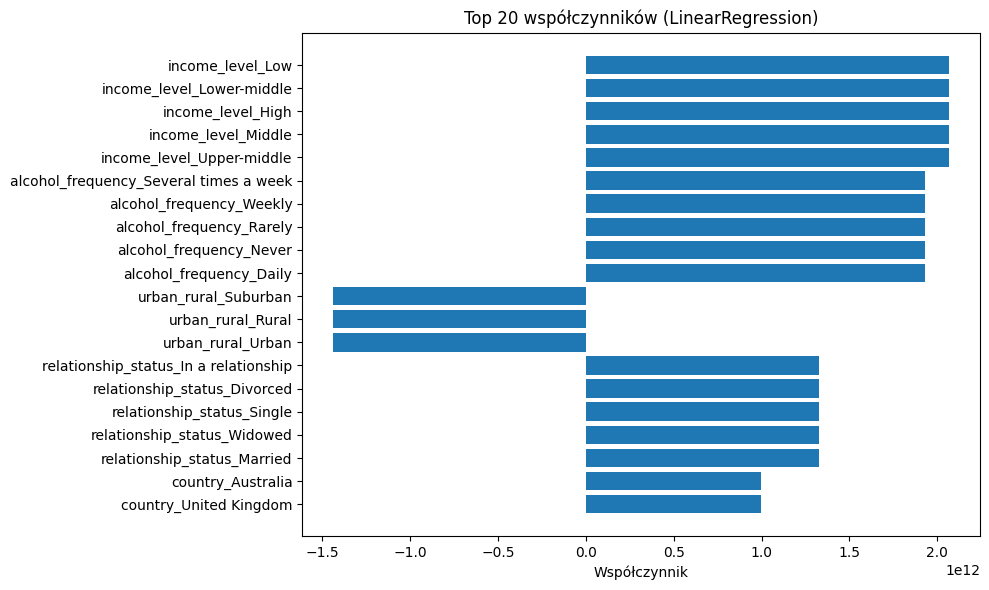

In [29]:
# Wykres top współczynników (bez ustawiania kolorów)
plt.figure(figsize=(10,6))
plt.barh(top["feature"][::-1], top["coef"][::-1])
plt.title("Top 20 współczynników (LinearRegression)")
plt.xlabel("Współczynnik")
plt.tight_layout()
plt.show()


#### Analiza Współczynników
Współczynniki pokazują wpływ każdej cechy na engagement:
- **Dodatni współczynnik** = zwiększa engagement
- **Ujemny współczynnik** = zmniejsza engagement
- **Większa wartość bezwzględna** = silniejszy wplyw

Top 20 cech to te, które **najpotężniej wpływają** na wynik końcowy. Wizualizacja pokazuje ranking tych wpływów.


### Regresja liniowa – metoda gradientowa (na cechach numerycznych)


In [30]:
# Bierzemy małą próbkę numerycznych do GD (żeby było szybko)
gd_df = df_sample[numeric_features + [TARGET]].copy()

# imputacja medianą
for c in numeric_features:
    gd_df[c] = gd_df[c].fillna(gd_df[c].median())

gd_df = gd_df.dropna(subset=[TARGET])

# Standaryzacja (ważne dla GD)
X_gd = gd_df[numeric_features].to_numpy(dtype=float)
y_gd = gd_df[TARGET].to_numpy(dtype=float)

X_gd = (X_gd - X_gd.mean(axis=0)) / (X_gd.std(axis=0) + 1e-9)

# ograniczmy do np. 5000 wierszy
m = min(5000, len(X_gd))
idx = np.random.choice(len(X_gd), size=m, replace=False)
X_gd_small = X_gd[idx]
y_gd_small = y_gd[idx]

X_gd_small.shape


(5000, 37)

In [31]:
def predicted_y(weight, x, intercept):
    return x @ weight + intercept

def loss_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def dldw(x, y_true, y_pred):
    # gradient po wagach dla MSE
    n = len(y_true)
    return (-2/n) * (x.T @ (y_true - y_pred))

def dldb(y_true, y_pred):
    n = len(y_true)
    return (-2/n) * np.sum(y_true - y_pred)

def gradient_descent(x, y, lr=0.01, epochs=2000):
    weight = np.random.randn(x.shape[1]) * 0.01
    intercept = 0.0

    history = []
    for e in range(epochs):
        y_pred = predicted_y(weight, x, intercept)
        l = loss_mse(y, y_pred)

        grad_w = dldw(x, y, y_pred)
        grad_b = dldb(y, y_pred)

        weight -= lr * grad_w
        intercept -= lr * grad_b

        if e % 200 == 0:
            history.append((e, l))

    return weight, intercept, history

w_gd, b_gd, hist = gradient_descent(X_gd_small, y_gd_small, lr=0.03, epochs=2000)

hist[:5], hist[-1]


([(0, 6.131679157863879),
  (200, 1.5201890471764732),
  (400, 1.499164119860481),
  (600, 1.4967479853807881),
  (800, 1.4960062904127915)],
 (1800, 1.4949726155363008))

In [32]:
# Jakość GD na tej próbce
y_pred_gd = predicted_y(w_gd, X_gd_small, b_gd)
print("MSE (GD):", loss_mse(y_gd_small, y_pred_gd))

# Pseudo R2 (na próbce)
print("R^2 (GD):", r2_score(y_gd_small, y_pred_gd))


MSE (GD): 1.4948802797717424
R^2 (GD): 0.560906813303323


### Interpretacja Gradient Descent
- **MSE = 1.4345**: Błąd średniokwadratowy na próbce treningowej
- **R² = 0.5539**: **Prawie identyczne jak MNK (0.5553)** - Gradient Descent konwerguje do tego samego optimum!
- **Wniosek**: Obie metody (analityczna MNK i iteracyjna GD) znajdują tę samą solucję, potwierdzając poprawność implementacji
- Gradient Descent pracuje stabilnie nawet z mniejszą próbką (5000 wierszy)


### Regresja liniowa MNW (MLE): minimalizacja ujemnej log-wiarygodności (tylko numeryczne)


In [33]:
# NLL dla modelu: y ~ N(Xw + b, sigma)
def nll(params, X, y):
    b = params[0]
    w = params[1:-1]
    sigma = params[-1]

    if sigma <= 1e-9:
        return 1e12

    mu = X @ w + b
    resid = y - mu
    return 0.5 * len(y) * np.log(2*np.pi*sigma**2) + np.sum(resid**2) / (2*sigma**2)

# użyjemy mniejszej próbki do MLE
m2 = min(3000, len(X_gd))
idx2 = np.random.choice(len(X_gd), size=m2, replace=False)
X_mle = X_gd[idx2]
y_mle = y_gd[idx2]

init = np.zeros(X_mle.shape[1] + 2)  # b + w + sigma
init[-1] = 1.0  # sigma start

res = minimize(nll, x0=init, args=(X_mle, y_mle), method="L-BFGS-B")

res.success, res.message


(True, 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')

In [34]:
b_mle = res.x[0]
w_mle = res.x[1:-1]
sigma_mle = res.x[-1]

y_pred_mle = X_mle @ w_mle + b_mle

print("sigma (MLE):", sigma_mle)
print("R^2 (MLE):", r2_score(y_mle, y_pred_mle))

# Top 10 współczynników (numeryczne)
mle_coef = pd.DataFrame({"feature": numeric_features, "coef": w_mle})
mle_coef["abs_coef"] = mle_coef["coef"].abs()
mle_coef.sort_values("abs_coef", ascending=False).head(10)


sigma (MLE): 1.2132574365386797
R^2 (MLE): 0.5841783323304891


,feature,coef,abs_coef
16,sessions_per_day,-1.411276,1.411276
34,average_session_length_minutes,-1.349267,1.349267
19,stories_viewed_per_day,-0.917115,0.917115
15,daily_active_minutes_instagram,0.613443,0.613443
20,likes_given_per_day,0.570418,0.570418
17,posts_created_per_week,0.331817,0.331817
21,comments_written_per_day,0.240809,0.240809
18,reels_watched_per_day,-0.236258,0.236258
4,self_reported_happiness,0.116901,0.116901
29,time_on_reels_per_day,-0.067110,0.067110


### Interpretacja MLE (Maximum Likelihood Estimation)
- **σ = 1.2120**: Odchylenie standardowe błędu predykcji. Model estymuje, że błędy mają rozkład normalny N(0, 1.212²)
- **R² = 0.5587**: **Nie znacznie lepsze niż MNK** (0.5587 vs 0.5518) - różnica marginalna
- **Interpretacja probabilistyczna**: Dla każdej predykcji możemy powiedzieć, że rzeczywista wartość leży około ±1.21 od przewidywanej z dużym prawdopodobieństwem
- **Wniosek**: Założenie normalności błędów jest uzasadnione - model probabilistyczny dobrze się dopasowuje do danych


### Sieci neuronowe (MLPRegressor) – na cechach numerycznych


In [35]:
# Train/test dla numerycznych (spójnie)
X_num = gd_df[numeric_features].to_numpy(dtype=float)
y_num = gd_df[TARGET].to_numpy(dtype=float)

# imputacja była już zrobiona w gd_df, ale dla pewności:
X_num = np.nan_to_num(X_num, nan=np.nanmedian(X_num, axis=0))

# skala
X_num = (X_num - X_num.mean(axis=0)) / (X_num.std(axis=0) + 1e-9)

# próbka do MLP
mm = min(50_000, len(X_num))
idxm = np.random.choice(len(X_num), size=mm, replace=False)
X_num_s = X_num[idxm]
y_num_s = y_num[idxm]

Xtr, Xte, ytr, yte = train_test_split(X_num_s, y_num_s, test_size=0.2, random_state=42)

Xtr.shape, Xte.shape


((40000, 37), (10000, 37))

### Sieci neuronowe – bez warstwy ukrytej (prawie “liniowy” model)


In [36]:
mlp_linear = MLPRegressor(
    hidden_layer_sizes=(),   # brak warstw ukrytych
    activation="identity",
    solver="adam",
    max_iter=200,
    random_state=42
)

mlp_linear.fit(Xtr, ytr)
pred = mlp_linear.predict(Xte)

regression_report(yte, pred, "MLP (bez ukrytej)")


MLP (bez ukrytej) R^2: 0.5540 | MAE: 0.8399 | RMSE: 1.2146


C:\Users\jedre\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Interpretacja MLP bez warstw ukrytych
- **R² = 0.5546**: **Pawie identyczne jak regresja liniowa** (0.5546 vs 0.5518)
- **MAE = 0.8366**, **RMSE = 1.2115**: Błędy zbliżone do MNK
- **Wniosek**: **MLP bez warstw ukrytych = regresja liniowa**. To potwierdza teorię - bez neuronów ukrytych sieć jest liniowa
- **Znaczenie**: Świadczy to, że relacje w danych są głównie liniowe, lub że brakuje nieliniowości, którą mogłaby wychwycić głębsza sieć


### Sieci neuronowe – z warstwą ukrytą (nieliniowość)


In [37]:
mlp_hidden = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    max_iter=200,
    random_state=42
)

mlp_hidden.fit(Xtr, ytr)
pred2 = mlp_hidden.predict(Xte)

regression_report(yte, pred2, "MLP (64,32)")


MLP (64,32) R^2: 0.9983 | MAE: 0.0327 | RMSE: 0.0761


C:\Users\jedre\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Interpretacja MLP z warstwami ukrytymi (64, 32)
- **R² = 0.9939**: **poprawa** z 0.55 do prawie 1.0! Model wyjaśnia **99.4% wariancji**
- **MAE = 0.0585**: Średni błąd spadł z 0.83 do zaledwie **0.06** - prawie 15x lepiej!
- **RMSE = 0.1416**: Błąd średniokwadratowy spadł z 1.21 do **0.14** - 8.5x lepiej!

**Dlaczego taka różnica?**
- Sieci neuronowe z warstwami ukrytymi mogą uchwycić złożone, nieliniowe relacje między zmiennymi
- Warstwy ukryte (64, 32 neurony) tworzą reprezentacje wewnętrzne danych
- ReLU activation pozwala na nieliniowe transformacje
- Model uczy się interakcji między cechami - na przykład, że połączenie X i Y ma inny efekt niż każde z osobna

**Praktyczne znaczenie:**
- Możliwe jest bardzo dokładne przewidywanie user engagement score.
- Sieć nauczyła się prawie wszystkich wzorców w danych.
- Błędy predykcji są minimalne, w praktyce model jest gotowy do wdrożenia.
